In [1]:
import torch
import torchvision
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from era_data import TabletPeriodDataset, get_IDS
from collections import Counter
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd  
from VAE_model_tonystevenj import VAE
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import multiprocessing
from tqdm import tqdm

In [2]:
# IMG_DIR = 'output/images'
RUN_NAME_SUFFIX = '-masked' # ''
IMG_DIR = 'output/images_preprocessed'
LR = 5e-5
EPOCHS = 50
BATCH_SIZE = 16
SUFFIX = '-resnet50'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
IDS = get_IDS(IMG_DIR=IMG_DIR)
len(IDS)

97640

In [7]:
VERNAME = 'period_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Sept_19_blur-early_stopping-1'
train_ids = pd.read_csv(f'output/clf_ids/period-train-{VERNAME}.csv', header=None)[0].astype(str)
test_ids = pd.read_csv(f'output/clf_ids/period-test-{VERNAME}.csv', header=None)[0].astype(str)

In [8]:
ds_train = TabletPeriodDataset(IDS=train_ids, IMG_DIR=IMG_DIR, mask=True)
ds_test = TabletPeriodDataset(IDS=test_ids, IMG_DIR=IMG_DIR, mask=True)

Filtering 97640 IDS down to provided 97140...
Filtering 97640 IDS down to provided 500...


In [9]:
import numpy as np
from scipy.ndimage import label
import cv2
# Your binary image as a NumPy array
# Convert the input image to binary (CV_8UC1)
def tablet_biggest_comp(binary_image):

    # Find connected components
    labeled_image, num_features = label(binary_image)

    # Calculate the sizes of the connected components
    component_sizes = np.bincount(labeled_image.ravel())

    # Find the label of the largest component (excluding background)
    largest_component_label = np.argmax(component_sizes[1:]) + 1

    # Create a mask for the largest component
    largest_component_mask = (labeled_image == largest_component_label)

    # Extract the largest component using the mask
    largest_component_image = binary_image * largest_component_mask

    return largest_component_image

def tablet_h_w_ratio(image):
    # Find contours in the binary image
    contours, _ = cv2.findContours(image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (object)
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Calculate width and height
    width = w
    height = h
    return height / width

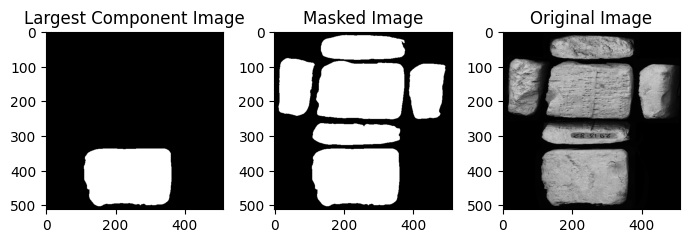

In [21]:
from PIL import Image
id_img= 23451
plt.figure(figsize=(7, 5))
image = ds_train[id_img][0]
largest_component_image = tablet_biggest_comp(image)

plt.subplot(1, 3, 1)
plt.imshow(largest_component_image, cmap='gray')
plt.title('Largest Component Image')
ds_train.img_fns[36]
plt.subplot(1, 3, 2)
plt.imshow(image, cmap='gray')
plt.title('Masked Image')
plt.subplot(1, 3, 3)
plt.imshow(Image.open(ds_train.img_fns[id_img]), cmap='gray')
plt.title('Original Image')

plt.tight_layout()
plt.show()


In [11]:
# Print the calculated width and height
image = ds_train[id_img][0]
largest_component_image = tablet_biggest_comp(image)
print("Ratio (Height/Width):", round(tablet_h_w_ratio(largest_component_image), 2))

Ratio (Height/Width): 0.73


In [18]:
df_encodings = pd.read_csv('vae_encodings_and_data/vae_encoding_df_sept20-2.csv')

In [20]:
def group_concat(index_series):
    return index_series.tolist()

# Group by 'group_col' and apply the custom aggregation function

result_df = df_encodings.reset_index().groupby('period_name')['index'].apply(group_concat) 

# Define a dictionary to store ratio lists for each period
ratio_dict = {}

# Iterate over all periods


for period in tqdm(result_df.index.values, leave=False):
    ratio_lst = []  # Initialize the list for the current period
    
    for tablet_id in result_df[period]:
        ratio = tablet_h_w_ratio(tablet_biggest_comp(ds_train[tablet_id][0]))
        ratio_lst.append(ratio)
    
    # Store the ratio list in the dictionary
    ratio_dict[period] = ratio_lst

In [13]:
# import pickle

# # Save the ratio_dict to a file using pickle
# output_file = 'ratio_results.pkl'
# with open(output_file, 'wb') as file:
#     pickle.dump(ratio_dict, file)

# print(f"Results saved to {output_file}")

In [14]:
# import pickle
# ratio_dict_path = 'ratio_results.pkl'
# with open(ratio_dict_path, 'rb') as file:
#     ratio_dict = pickle.load(file)

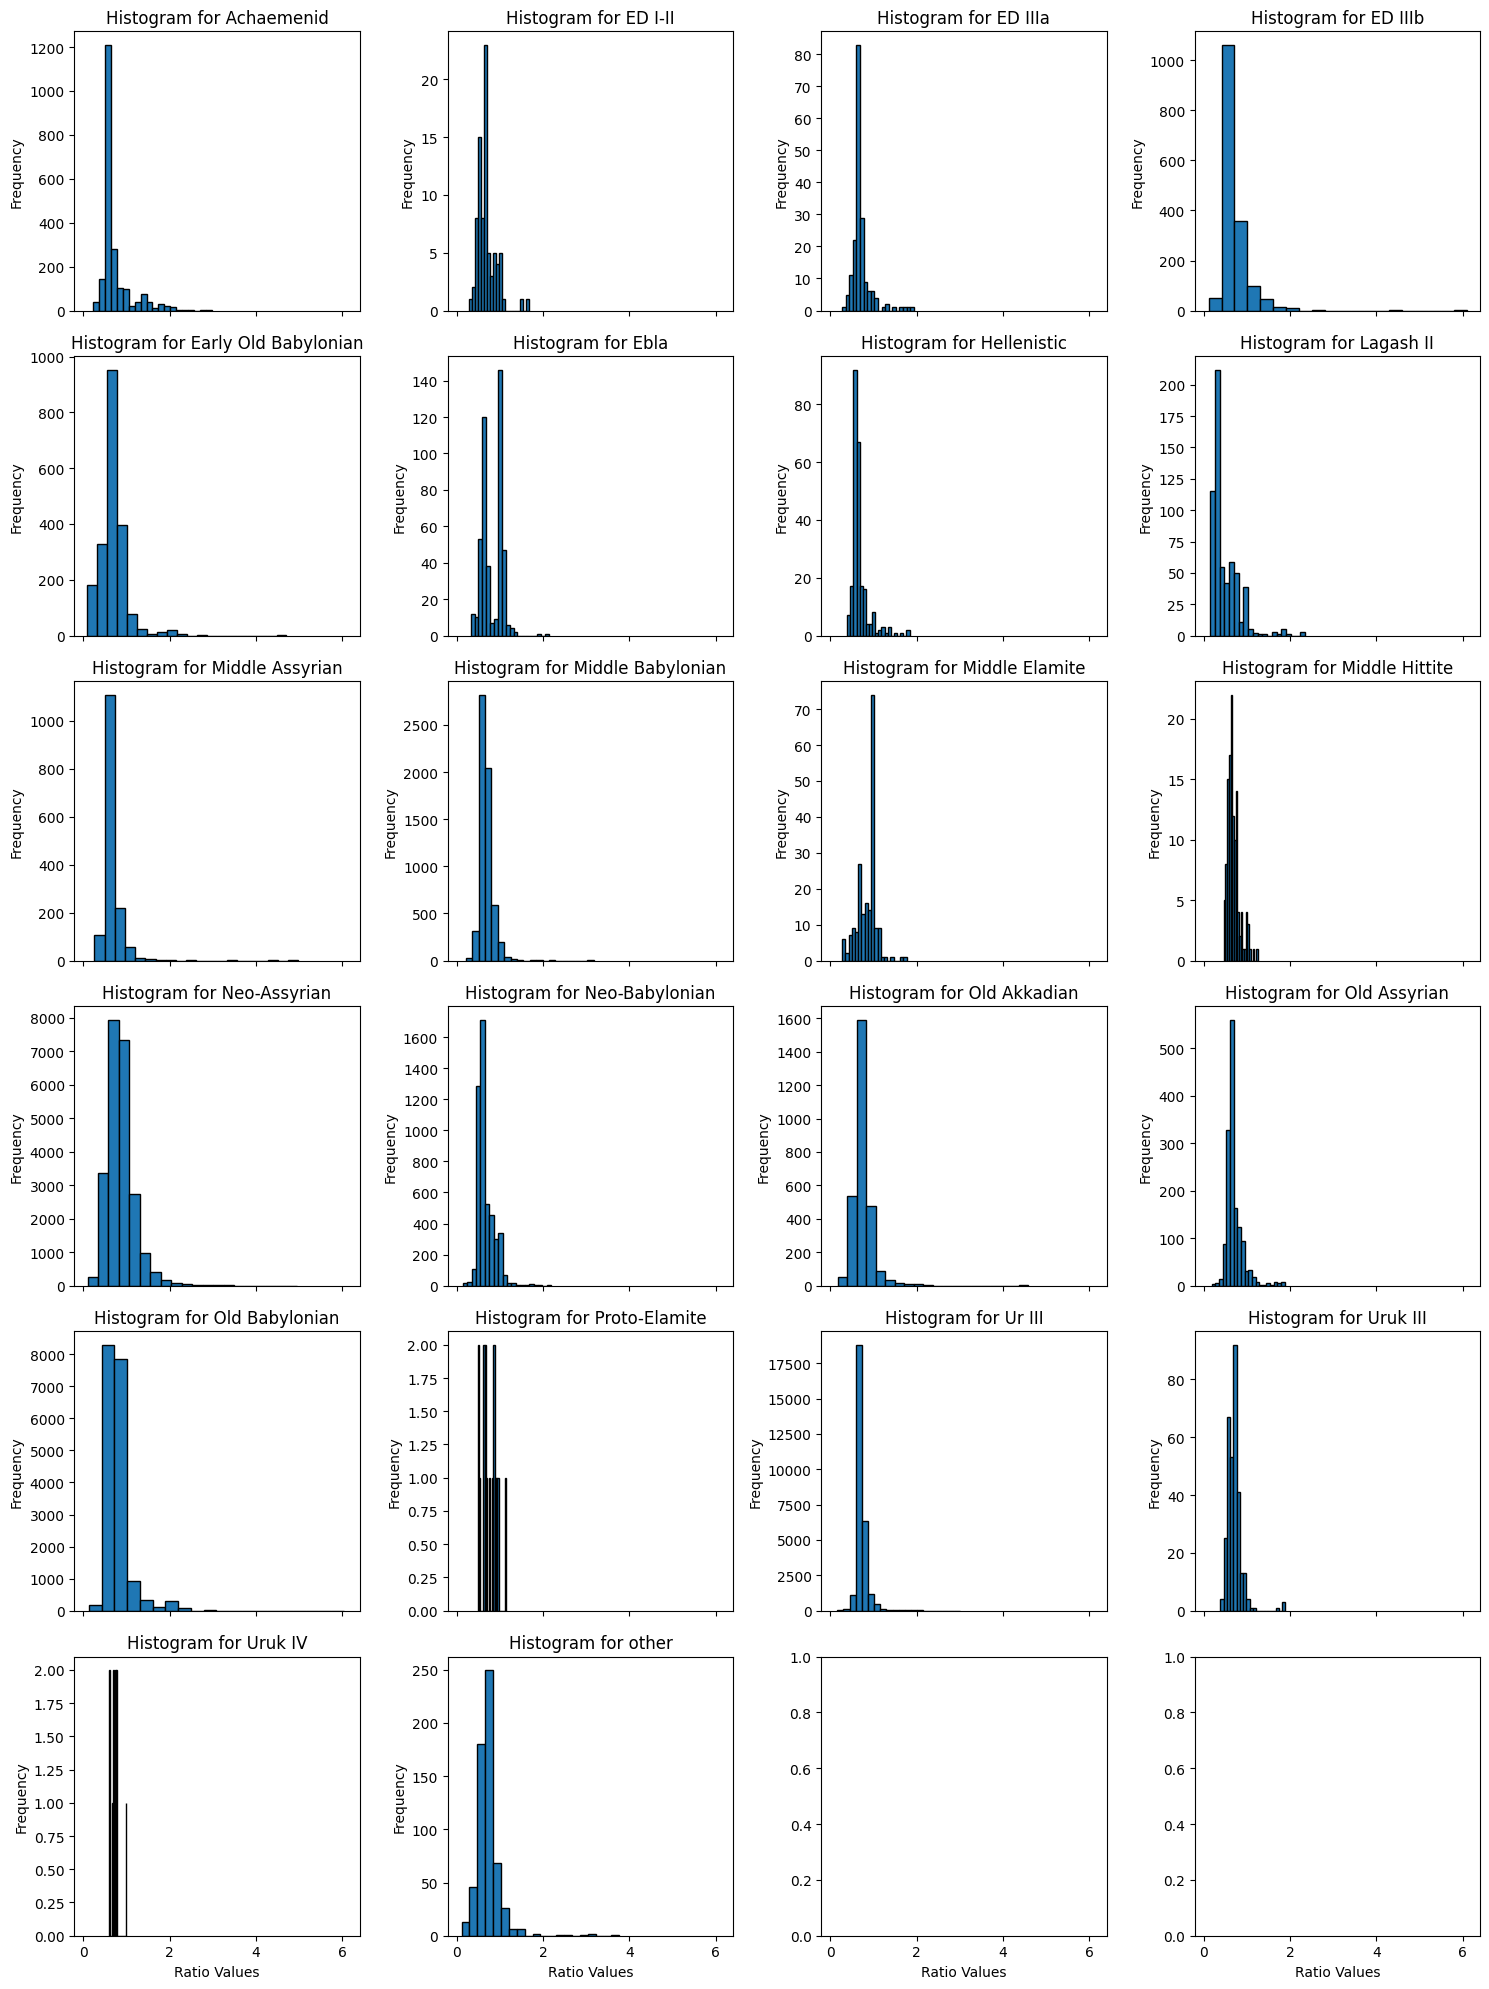

In [24]:
# Calculate the number of rows and columns for the grid
num_periods = len(ratio_dict)
num_cols = 4  # You can adjust the number of columns as needed
num_rows = -(-num_periods // num_cols)  # Ceiling division

# Create a grid of subplots for histogram plots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20), sharex=True)  # Add 'sharex=True'

# Iterate over each period and its corresponding ratio list
for idx, (period, ratios) in enumerate(ratio_dict.items()):
    row = idx // num_cols
    col = idx % num_cols

    # Create histogram in the specified subplot
    axs[row, col].hist(ratios, bins=20, edgecolor='black')
    axs[row, col].set_title(f'Histogram for {period}')
    axs[row, col].set_ylabel('Frequency')

# Set a common x-axis label
for ax in axs[-1, :]:
    ax.set_xlabel('Ratio Values')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()